# Roulette Strategies with Limited Cash

Suppose we fortuituously find ourselves in a Casino, and approach the Roulette Table.

This is, indeed, a peculiar roulette table, since it is missing the green case.

The well-known Martingale Strategy for 50-50 roulette states that, if we select one of {${R, B}$} - it doesn't matter which one - betting $2^{n-1}$ for each round $n = 1, 2, ...,$ and stopping once we record a win - say, at time N: 

##### Then, the total P&L of our game will be $G_0 = 2^{N-1} + \sum_{n = 1}^{N-1}{{-2}^{n-1}} = 1$
with probability 1.

The expected playing time is the expected number of hands before witnessing a $R$ (or $B$), which is trivially equal to $2$ (One can argue this via the standard martingale approach, setting up a value process $W$ such that ${({W_t - t})}_{t>0}$ is a martingale. Use linearity and Optional Sampling to conclude $E[W_\tau] = E[\tau]$)

However, this infamously naive approach relies on the key assumption that we "have infinite cash" when stepping foot in the Casino.
Relaxing this condition, and hence generating games <code> game(K) </code>as a function of cash K, we intuitively arrive to the conclusion that we gain that 1 dollar with probability less then 1.

Next, we will also relax the (utterly unrealistic) scenario that we encounter a 50-50 table. In other words, we will re-introduce the green case.

We set up a computational tool to estimate this new probability, as well as the expected playing time

Additional (formal) derivations will be provided at a later stage

For simplicity, let us isomorphically map {${R, B}$} to {${0, 1}$}. Assume from now on that we are betting on $1$

In [3]:
import numpy as np

## Single Games

In [4]:
def expected_gains(K):

    'Input: K - the cash I have in the bank'

    cash = K
    outputs = []

    n_game = 1
    cash -= 1
    a = np.random.choice([0, 1])
    outputs.append(a) #simulate first bet and output of the first round: in this way we can make sense of "last element of the streak"!

    if outputs[-1] == 1: #if we win straight away, then we pocket $1 and get out!
        cash += 2
        return cash - K

    else: #otherwise, we keep in game: if we don't see a 1 yet, play again. We immediately observe the output of the play: if it is 0, we lose 2^(n-1)
        while ~(outputs[-1] == 1):
            
            n_game += 1
            a = np.random.choice([0, 1])
            outputs.append(a)
            if ~(outputs[-1] == 1):
                cash -= 2**(n_game - 1)
            if cash < 0: #if we run out of money, we can't invest in the game anymore. We assume we can lose more than we initially have
                return cash - K 
    
        cash += 2**(n_game - 1) #as soon as we observe that our last element is 1, we win!

        cash - K
        return cash - K 

We also provide a slightly modified version, which keeps track of the rounds and final cash P&L:

In [5]:
def cards(K):

    'Input: K - the cash I have in the bank'

    cash = K
    outputs = []

    n_game = 1
    cash -= 1
    a = np.random.choice([0, 1])
    outputs.append(a) #simulate first bet and output of the first round: in this way we can make sense of "last element of the streak"!

    if outputs[-1] == 1: #if we win straight away, then we pocket $1 and get out!
        profits = 1
        return (outputs, profits)
    
    else: #otherwise, we keep in game: if we don't see a 1 yet, play again. We immediately observe the output of the play: if it is 0, we lose 2^(n-1)
        while ~(outputs[-1] == 1):
            n_game += 1
            a = np.random.choice([0, 1])
            outputs.append(a)
            if ~(outputs[-1] == 1):
                cash -= 2**(n_game - 1)
            if cash < 0:

                return (outputs, -K)
        
        cash += 2**(n_game - 1) #as soon as we observe that our last element is 1, we win!

        profits = cash - K
        return (outputs, profits) 

In [6]:
print(expected_gains(5))

print(cards(5))

-7
([0, 1], 1)


Now let us simulate N games

In [7]:
def expected_gains_N(N, K):
    out = 0
    n_games = N
    for i in range(n_games):
        out += expected_gains(K)
    return out/N

In [8]:
N = 100000
K = 10

expected_gains_N(N, K)

0.01632

Here we have two trends to identify: what happens when N grows and what happens when K grows.

The former trend isn't particularly interesting (by i.i.d. and the Strong Law of Large Numbers one would expect convergence).

The latter, however, is't of immediate approach, as a higher cash amount should guarantee a more likely "win", but in case of a loss the economic weight would be disastrous.

Translated in gambler's terms:
 
When betting via the martingale strategy, is it better to walk in full of cash or with little money in our hands? 

In [9]:
N = 1000
ranges = 10000

xs = [n for n in range(ranges)]
ys = [expected_gains_N(N, k) for k in xs]

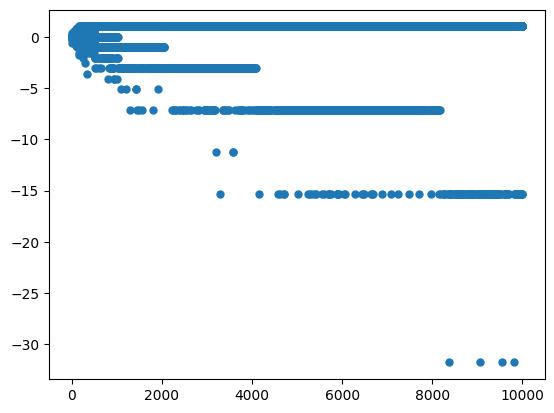

In [10]:
import matplotlib.pyplot as plt
plt.scatter(xs, ys, lw = 0.01)

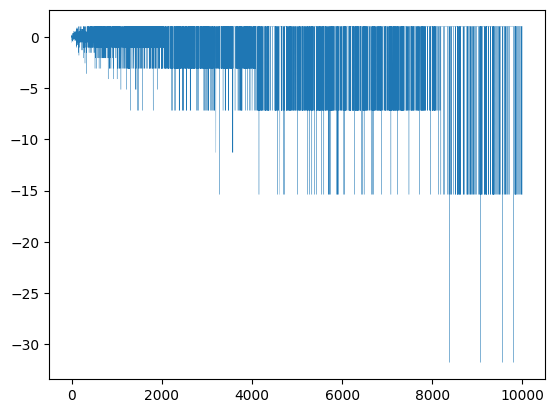

In [11]:
plt.plot(xs, ys, lw = 0.2)

We observe that the higher concentration is between -1 and 1, as one would probably expect.
Indeed, we don't observe proper (visible) convergence, rather a sort of divergence as K grows.
One could conjecture that the "higher security" given by having more resources is offset by the unlucky event of losing it all: while we could have initially guessed that this negative effect would balance the positive effect, these charts actually suggest that the chance of much higher losses annihiltes our expected value for the game.

Or, to put it more spectacularly:

#### Conjecture: When Doubling Down, being Rich is Worse than Being Poor

After giving it some thought, the above (hypothetical, still) result doesn't seem so unreasonable.

The upsides of having a lot of cash are bounded: you maximize the probability of securing your $1 profit, but that's it! It doesn't give you the chance of winning additional amounts. However, the potential losses are proportional to what you have at stake, which grows linearly as K grows.

This is the result for single-game simulations. That is, we simulated $N$ 1-game scenarios, where the player walks off after the first $1$, either with $1 or having lost everything.

Things change considerably when considering a multi-game scenario: the player continues playing until he has cash to spare.
The issue is, of course, that with positive probability the player will continue to play forever if nobody stops him, and hence certain $\omega$ in out probability space $(\Omega, F, P)$ will yield a never-ending computation!

Hence, we introduce an arbitrary "stop-loss": the player plays until he reaches a pre-determined target.

## Repeated Games (with Stop-Loss)

In [12]:
def repeated_game(K, T):

    'Inputs: K: initial cash; T: stop-win target'

    cash = K

    while T > cash > 0:

        cash += expected_gains(cash)
  
    return cash - K

In [13]:
repeated_game(100, 1000)

-109

In [14]:
def repeated_game_N(N, K, T):
    out = 0
    n_games = N
    for i in range(n_games):
        out += repeated_game(K, T)
    return out/N

In [15]:
repeated_game_N(1000,100, 1000)

20.669

Since we have a 3-d problem to investigate, observing trends becomes a visualizational challenge. 

Let us approach it this way: fix an N (1000 seems a reasonable amount), and let the ratio between what you have and what your goal is (i.e. your expected return on your investment, so to speak) range from 1.1 to 2 (i.e. suppose your aspirations range from a 10% return to doubling your money)

In [16]:
N = 1000
K = 1000
num = 100

In [17]:
ratios = np.linspace(1.1, 2, num)
ys = [repeated_game_N(N, K, K*k) for k in ratios]

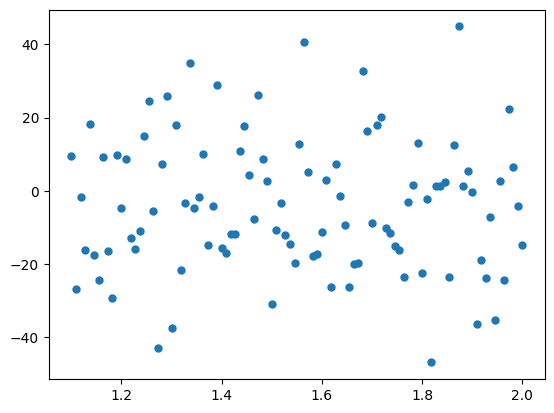

In [18]:
plt.scatter(ratios, ys, lw = 0.01)

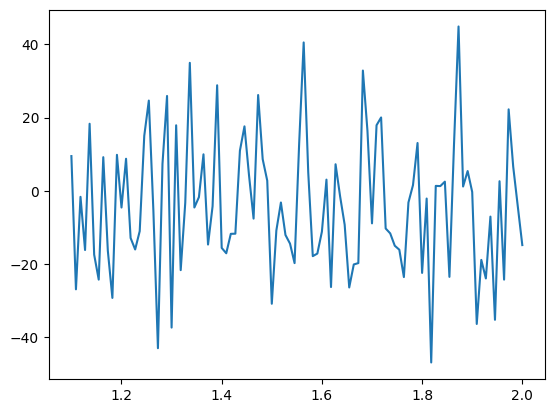

In [19]:
plt.plot(ratios, ys)

An even more useful visualization would be to plot the expected return vs the actual return

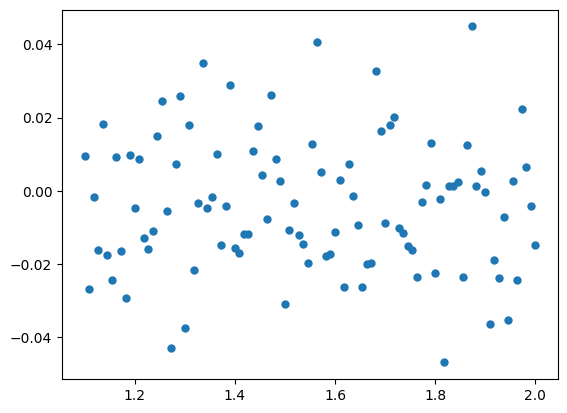

In [20]:
zs = [x/K for x in ys]
plt.scatter(ratios, zs, lw = 0.01)

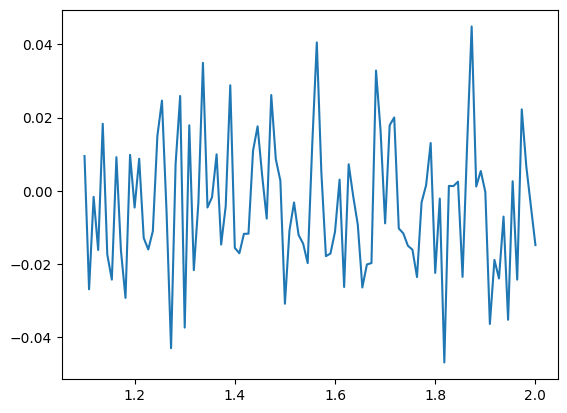

In [21]:
plt.plot(ratios, zs)

#### Plotting the "feasability" coefficient of your target

In [28]:
def expect_vs_real(N, K, num):
    expec = np.linspace(1.1, 2, num)
    real = [repeated_game_N(N, K, K*k)/K for k in expec]
    ratio = real/expec
    plt.plot(expec, ratio)

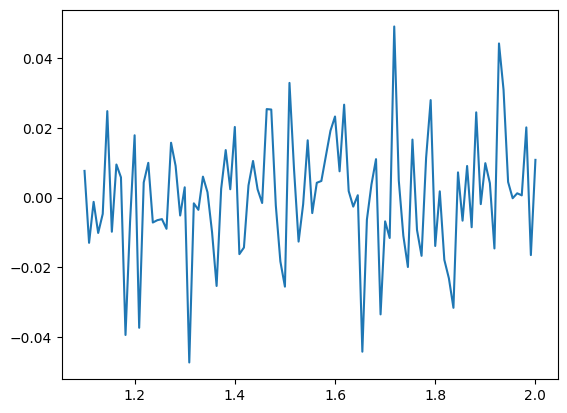

In [30]:
N = 1000
K = 3000
num = 100

expect_vs_real(N, K, num)

<u>Interpretation of the Above </u>:

<b> Setup </b>:
Say we enter a casino with $3000 (relatively speaking, we are rich!) and sit down at a 50-50 roulette table. 

We need to select a target return for our night. The rules are: you play the martingale (doubling down) strategy until you either lose everything (in this case, the whole $3000, yielding a -100% return), or until you reach your target.

For what expected return r are your expectation closer to the realized return?
We imagine the player wants to select the most "realistic" expectation for his return, and hence is focused on avoiding disappointment rather than gaining more money.

<b>Output</b>:
The observations are very noisy, but in general for all targets the realized returns are less than 5% of the expected ones. 

#### <u> Could this suggest that, if open to take more downward risk, you should overshoot by 20-25x to get your desired return? </u>

This way, your returns would be in the range $[-r, r]$, with r being your desired return

Obviously, if the player isn't satisfied by a low return and is waiting for a higher return, he has the chance of making more money. It is also of intuitive understanding that this has the opposite effect of making him risk more by staying at the table longer. Hence, with fixed initial cash $K$, the player with higher expectation has higher (two-sided)  variance in his returns.

However, even if two-sided, this variance doesn't seem to be a martingale with respect to the expected return: we can conjecture a slightly upward-leaning trend, but would need a wider range of returns to determine this